# Real estate price prediction using ML 

This project aims to correctly predict real estate prices in Madrid based on a publicly available dataset, after doing some data cleaning and exploration. It takes the initial EDA from a notebook from Kaggle and I apply a tuned RandomForest Regressor, one of the models we have seen in class.  

**Best result: 92% R-squared score using tuned random forest** 

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
sns.set()
import bz2

In [2]:
#importing data from csv file
raw_data = pd.read_csv('houses_Madrid.csv')

pd.set_option("display.max_columns", None)
# exploring the top 5 rows of the data
raw_data_reset = raw_data.reset_index(drop=True)


In [3]:
raw_data.describe(include='all')

,Unnamed: 0,id,title,subtitle,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,latitude,longitude,raw_address,is_exact_address_hidden,street_name,street_number,portal,floor,is_floor_under,door,neighborhood_id,operation,rent_price,rent_price_by_area,is_rent_price_known,buy_price,buy_price_by_area,is_buy_price_known,house_type_id,is_renewal_needed,is_new_development,built_year,has_central_heating,has_individual_heating,are_pets_allowed,has_ac,has_fitted_wardrobes,has_lift,is_exterior,has_garden,has_pool,has_terrace,has_balcony,has_storage_room,is_furnished,is_kitchen_equipped,is_accessible,has_green_zones,energy_certificate,has_parking,has_private_parking,has_public_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east
count,21742.000000,21742.000000,21742,21742,21616.000000,8228.000000,21742.000000,21726.000000,1437.000000,1432.000000,0.0,0.0,16277,21742,15837,6300,0.0,19135,20572,0.0,21742,21742,2.174200e+04,0.0,21742,2.174200e+04,21742.000000,21742,21351,21742,20750,10000.000000,13608,13608,0.0,11211,13399,19356,18699,1556,5171,9548,3321,7698,0.0,0.0,4074,4057,21742,21742,0.0,0.0,7719,7719.000000,11358,11358,11358,11358
unique,NaN,NaN,10736,146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9666,2,6177,420,NaN,19,2,NaN,126,1,NaN,NaN,1,NaN,NaN,1,4,2,2,NaN,2,2,NaN,1,1,2,2,1,1,1,1,1,NaN,NaN,1,1,10,2,NaN,NaN,2,NaN,2,2,2,2
top,NaN,NaN,Piso en venta en El Viso,"Chamartín, Madrid",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paseo de la Castellana,True,Paseo de la Castellana,4,NaN,1,False,NaN,Neighborhood 23: Malasaña-Universidad (5196.25...,sale,NaN,NaN,False,NaN,NaN,True,HouseType 1: Pisos,False,False,NaN,False,True,NaN,True,True,True,True,True,True,True,True,True,NaN,NaN,True,True,en trámite,False,NaN,NaN,True,NaN,False,False,True,False
freq,NaN,NaN,193,851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94,15002,116,210,NaN,4440,18033,NaN,485,21742,NaN,NaN,21742,NaN,NaN,21742,17705,17747,19281,NaN,9516,9516,NaN,11211,13399,14895,16922,1556,5171,9548,3321,7698,NaN,NaN,4074,4057,10937,14023,NaN,NaN,7115,NaN,8567,7287,5823,6302
mean,10870.500000,10871.500000,NaN,NaN,146.920892,103.458192,3.005749,2.091687,3.128740,241.692737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.917031e+04,NaN,NaN,6.537356e+05,4020.523871,NaN,NaN,NaN,NaN,1970.046400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2658.000518,NaN,NaN,NaN,NaN
std,6276.519112,6276.519112,NaN,NaN,134.181865,88.259192,1.510497,1.406992,0.907713,247.484853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.171162e+05,NaN,NaN,7.820821e+05,1908.418774,NaN,NaN,NaN,NaN,69.386705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13360.966258,NaN,NaN,NaN,NaN
min,0.000000,1.000000,NaN,NaN,13.000000,1.000000,0.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.459028e+07,NaN,NaN,3.600000e+04,447.000000,NaN,NaN,NaN,NaN,1723.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
25%,5435.250000,5436.250000,NaN,NaN,70.000000,59.000000,2.000000,1.000000,2.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.250000e+02,NaN,NaN,1.980000e+05,2551.000000,NaN,NaN,NaN,NaN,1957.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
50%,10870.500000,10871.500000,NaN,NaN,100.000000,79.000000,3.000000,2.000000,3.000000,232.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.116000e+03,NaN,NaN,3.750000e+05,3720.000000,NaN,NaN,NaN,NaN,1970.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
75%,16305.750000,16306.750000,NaN,NaN,162.000000,113.000000,4.000000,2.000000,4.000000,354.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.687000e+03,NaN,NaN,7.636000e+05,5000.000000,NaN,NaN,NaN,NaN,1994.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

There is lots of data, some features including 21742 counts of data and
58 columns as outlined above. The features with the highest correlation with buy_price will be explored, as well as features logically would increase a given real estate's price. It makes sense that with the parameters below, the price would increase
e.g. more space (sq_mt_built) would increase the price, a newer house would be more expensive, south orientation is also very valuable, etc.

In [4]:
#removing unnecessary data from the model
data = raw_data.filter(['sq_mt_built','n_rooms','n_bathrooms', 'buy_price','buy_price_by_area','built_year',
                        'has_parking','is_orientation_south', 'has_lift','has_central_heating', 'subtitle'])

#checking what's left:
data.head()

,sq_mt_built,n_rooms,n_bathrooms,buy_price,buy_price_by_area,built_year,has_parking,is_orientation_south,has_lift,has_central_heating,subtitle
0,64.0,2,1.0,85000,1328,1960.0,False,False,False,NaN,"San Cristóbal, Madrid"
1,70.0,3,1.0,129900,1856,NaN,False,NaN,True,NaN,"Los Ángeles, Madrid"
2,94.0,2,2.0,144247,1535,NaN,False,NaN,True,False,"San Andrés, Madrid"
3,64.0,2,1.0,109900,1717,1955.0,False,True,True,NaN,"San Andrés, Madrid"
4,108.0,2,2.0,260000,2407,2003.0,True,True,True,NaN,"Los Rosales, Madrid"


In [6]:
data.describe(include='all')

,sq_mt_built,n_rooms,n_bathrooms,buy_price,buy_price_by_area,built_year,has_parking,is_orientation_south,has_lift,has_central_heating,subtitle
count,21616.000000,21742.000000,21726.000000,2.174200e+04,21742.000000,10000.000000,21742,11358,19356,13608,21742
unique,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,146
top,NaN,NaN,NaN,NaN,NaN,NaN,False,True,True,False,"Chamartín, Madrid"
freq,NaN,NaN,NaN,NaN,NaN,NaN,14023,5823,14895,9516,851
mean,146.920892,3.005749,2.091687,6.537356e+05,4020.523871,1970.046400,NaN,NaN,NaN,NaN,NaN
std,134.181865,1.510497,1.406992,7.820821e+05,1908.418774,69.386705,NaN,NaN,NaN,NaN,NaN
min,13.000000,0.000000,1.000000,3.600000e+04,447.000000,1723.000000,NaN,NaN,NaN,NaN,NaN
25%,70.000000,2.000000,1.000000,1.980000e+05,2551.000000,1957.000000,NaN,NaN,NaN,NaN,NaN
50%,100.000000,3.000000,2.000000,3.750000e+05,3720.000000,1970.000000,NaN,NaN,NaN,NaN,NaN
75%,162.000000,4.000000,2.000000,7.636000e+05,5000.000000,1994.000000,NaN,NaN,NaN,NaN,NaN


The built_year feature will be interesting to explore and its count of data points is only 10000, meaning more than half of the data for this feature is unavailable. We will use the fillna function with the average built_year so that we do not lose this valuable data.

In [5]:
#there is a disparity on the count of data points between different parameters
#summing the missing data points
data.isnull().sum()

sq_mt_built               126
n_rooms                     0
n_bathrooms                16
buy_price                   0
buy_price_by_area           0
built_year              11742
has_parking                 0
is_orientation_south    10384
has_lift                 2386
has_central_heating      8134
subtitle                    0
dtype: int64

In [6]:
# Fill missing datapoints with mean
columns_to_fill = data.columns[:-1]  # Exclude the last column
data[columns_to_fill] = data[columns_to_fill].fillna(data[columns_to_fill].mean())
data.isnull().sum()

sq_mt_built             0
n_rooms                 0
n_bathrooms             0
buy_price               0
buy_price_by_area       0
built_year              0
has_parking             0
is_orientation_south    0
has_lift                0
has_central_heating     0
subtitle                0
dtype: int64

We have thus filled missing data points.

# Dealing with outliers

<Axes: xlabel='buy_price', ylabel='Density'>

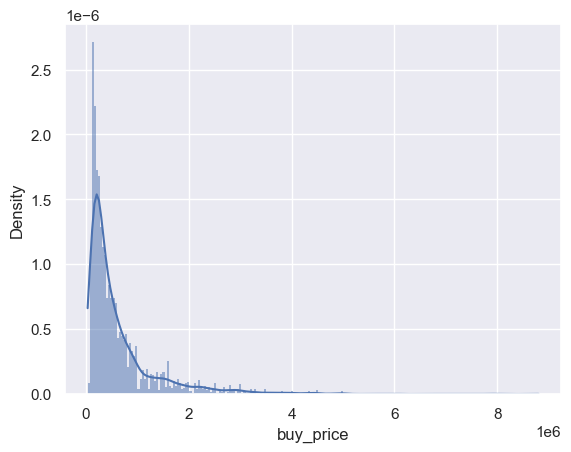

In [7]:
#let's explore the data further to get to know what the price distribution is
#this is valuable since we are trying to train the model to predict buy price
sns.histplot(data['buy_price'],kde=True, stat="density", linewidth=0)

There are some outliers present. Here, the outliers are situated around the higher prices (right side of the graph) and if the right side is excluded, the prices seem normally distributed. Outliers are a great issue for the model we will first use (ordinary least squares OLS).

In [8]:
# Let's declare a variable that will be equal to the 95th percentile of the 'buy_price' variable
q = data['buy_price'].quantile(0.95)

# Then we can create a new dataframe (df), with the condition that all prices must be below 
#the 95th percentile 
data = data[data['buy_price']<q]

data.describe(include='all')


,sq_mt_built,n_rooms,n_bathrooms,buy_price,buy_price_by_area,built_year,has_parking,is_orientation_south,has_lift,has_central_heating,subtitle
count,20587.000000,20587.000000,20587.000000,2.058700e+04,20587.000000,20587.000000,20587,20587.000000,20587,20587,20587
unique,NaN,NaN,NaN,NaN,NaN,NaN,2,3.000000,3,3,146
top,NaN,NaN,NaN,NaN,NaN,NaN,False,0.512678,True,False,"Chamartín, Madrid"
freq,NaN,NaN,NaN,NaN,NaN,NaN,13718,9901.000000,14316,9151,649
mean,128.659819,2.860640,1.915547,5.118365e+05,3885.937728,1970.007966,NaN,NaN,NaN,NaN,NaN
std,99.115504,1.336969,1.142888,4.432467e+05,1755.412336,48.092061,NaN,NaN,NaN,NaN,NaN
min,13.000000,0.000000,1.000000,3.600000e+04,447.000000,1723.000000,NaN,NaN,NaN,NaN,NaN
25%,70.000000,2.000000,1.000000,1.900000e+05,2500.000000,1970.046400,NaN,NaN,NaN,NaN,NaN
50%,96.000000,3.000000,2.000000,3.500000e+05,3638.000000,1970.046400,NaN,NaN,NaN,NaN,NaN
75%,148.000000,4.000000,2.000000,6.700000e+05,4867.000000,1970.046400,NaN,NaN,NaN,NaN,NaN


We can check the Probability Density Function (PDF) once again to ensure that the result is still distributed in the same way overall. It is, however, there are much fewer outliers:

<Axes: xlabel='buy_price', ylabel='Density'>

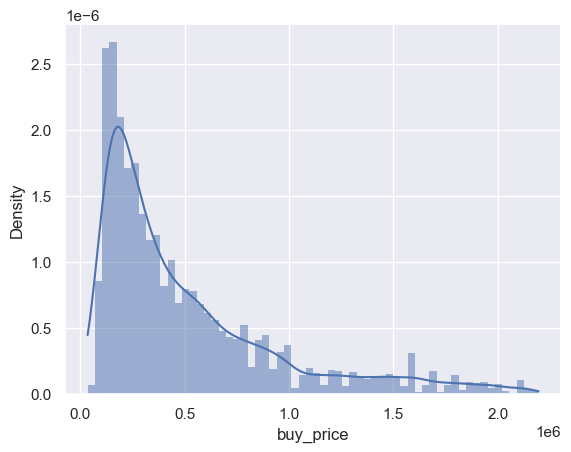

In [11]:
sns.histplot(data['buy_price'],kde=True, stat="density", linewidth=0)

By removing the outliers, the graph is much more concentrated on the real data points now,
it looks more 'normal' as in normally distributed. In general, removing 5% of the dataset should not pose data representativeness issues.

<Axes: xlabel='built_year', ylabel='Density'>

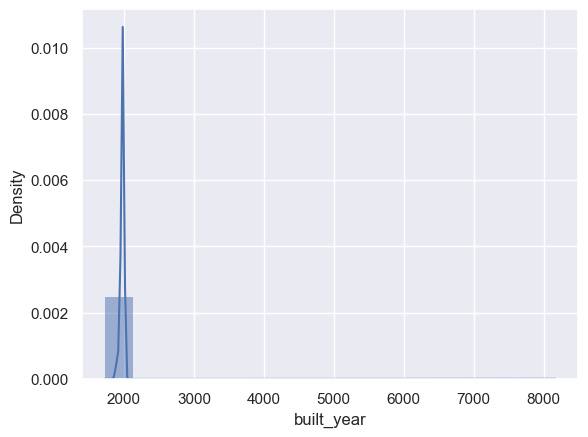

In [9]:
# The year built graph looks strange
sns.histplot(data['built_year'],kde=True, stat="density", linewidth=0)

<Axes: xlabel='built_year', ylabel='Density'>

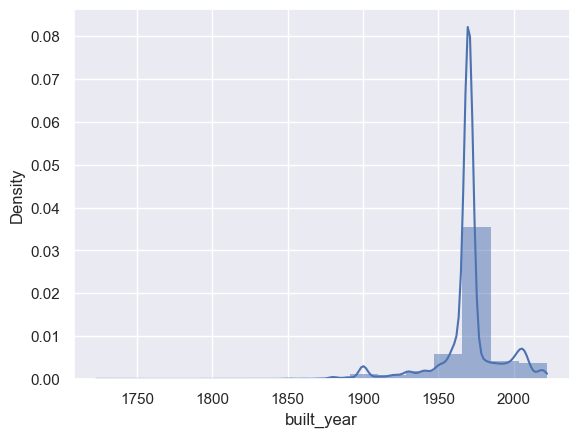

In [10]:
# there is an observation for a built_year in 8170, as can be seen above with the .describe() function.
# let's remove this observation:
data = data[data['built_year'] != 8170]
sns.histplot(data['built_year'],kde=True, stat="density", linewidth=0)

In [11]:
# resetting the index since some observations were dropped. 
data = data.reset_index(drop=True)

In [12]:
data.describe(include='all')

,sq_mt_built,n_rooms,n_bathrooms,buy_price,buy_price_by_area,built_year,has_parking,is_orientation_south,has_lift,has_central_heating,subtitle
count,20586.000000,20586.000000,20586.000000,2.058600e+04,20586.000000,20586.000000,20586,20586.000000,20586,20586,20586
unique,NaN,NaN,NaN,NaN,NaN,NaN,2,3.000000,3,3,146
top,NaN,NaN,NaN,NaN,NaN,NaN,False,0.512678,True,False,"Chamartín, Madrid"
freq,NaN,NaN,NaN,NaN,NaN,NaN,13717,9900.000000,14315,9151,649
mean,128.661696,2.860633,1.915592,5.118252e+05,3885.724376,1969.706791,NaN,NaN,NaN,NaN,NaN
std,99.117545,1.337001,1.142898,4.432545e+05,1755.188029,21.106719,NaN,NaN,NaN,NaN,NaN
min,13.000000,0.000000,1.000000,3.600000e+04,447.000000,1723.000000,NaN,NaN,NaN,NaN,NaN
25%,70.000000,2.000000,1.000000,1.900000e+05,2500.000000,1970.046400,NaN,NaN,NaN,NaN,NaN
50%,96.000000,3.000000,2.000000,3.500000e+05,3638.000000,1970.046400,NaN,NaN,NaN,NaN,NaN
75%,148.000000,4.000000,2.000000,6.700000e+05,4866.750000,1970.046400,NaN,NaN,NaN,NaN,NaN


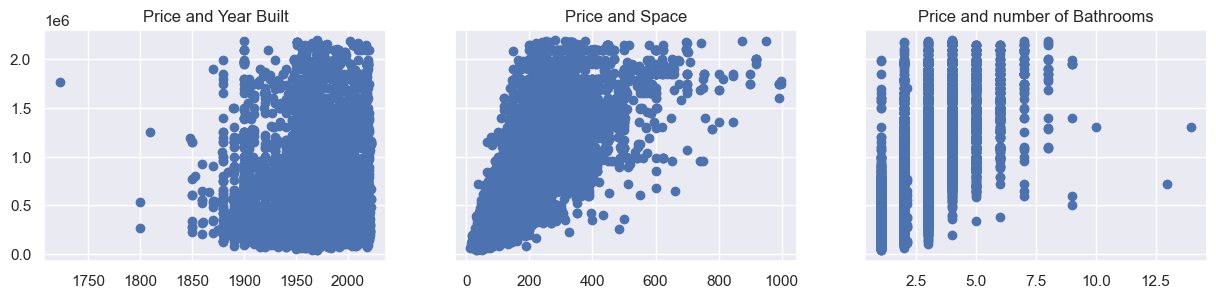

In [13]:
#plotting some parameters together

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,3)) #sharey -> share 'Price' as y
ax1.scatter(data['built_year'],data['buy_price'])
ax1.set_title('Price and Year Built')
ax2.scatter(data['sq_mt_built'],data['buy_price'])
ax2.set_title('Price and Space')
ax3.scatter(data['n_bathrooms'],data['buy_price'])
ax3.set_title('Price and number of Bathrooms')


plt.show()

In [14]:
# log transforming price
log_price = np.log(data['buy_price'])

# Then we add it to our data frame
data['log_price'] = log_price
data.head()

,sq_mt_built,n_rooms,n_bathrooms,buy_price,buy_price_by_area,built_year,has_parking,is_orientation_south,has_lift,has_central_heating,subtitle,log_price
0,64.0,2,1.0,85000,1328,1960.0000,False,False,False,0.300705,"San Cristóbal, Madrid",11.350407
1,70.0,3,1.0,129900,1856,1970.0464,False,0.512678,True,0.300705,"Los Ángeles, Madrid",11.774520
2,94.0,2,2.0,144247,1535,1970.0464,False,0.512678,True,False,"San Andrés, Madrid",11.879282
3,64.0,2,1.0,109900,1717,1955.0000,False,True,True,0.300705,"San Andrés, Madrid",11.607326
4,108.0,2,2.0,260000,2407,2003.0000,True,True,True,0.300705,"Los Rosales, Madrid",12.468437


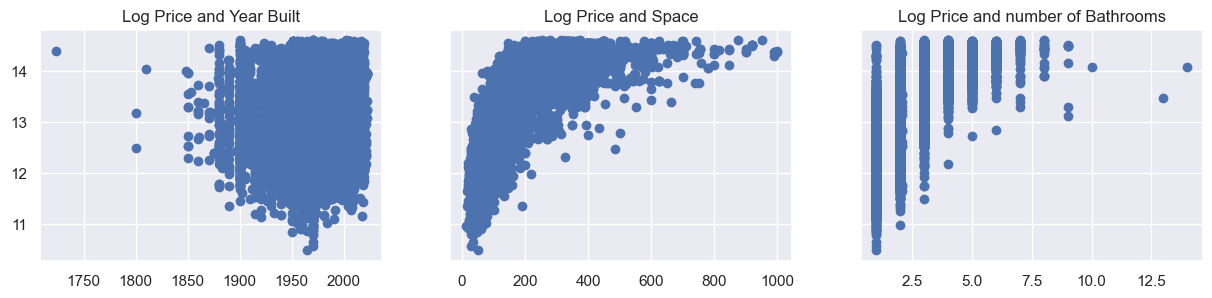

In [15]:
#log plots
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,3)) #sharey -> share 'Price' as y
ax1.scatter(data['built_year'],data['log_price'])
ax1.set_title('Log Price and Year Built')
ax2.scatter(data['sq_mt_built'],data['log_price'])
ax2.set_title('Log Price and Space')
ax3.scatter(data['n_bathrooms'],data['log_price'])
ax3.set_title('Log Price and number of Bathrooms')


plt.show()

In [16]:
# dropping the old buy price
data = data.drop(['buy_price'],axis=1)
data.head()

,sq_mt_built,n_rooms,n_bathrooms,buy_price_by_area,built_year,has_parking,is_orientation_south,has_lift,has_central_heating,subtitle,log_price
0,64.0,2,1.0,1328,1960.0000,False,False,False,0.300705,"San Cristóbal, Madrid",11.350407
1,70.0,3,1.0,1856,1970.0464,False,0.512678,True,0.300705,"Los Ángeles, Madrid",11.774520
2,94.0,2,2.0,1535,1970.0464,False,0.512678,True,False,"San Andrés, Madrid",11.879282
3,64.0,2,1.0,1717,1955.0000,False,True,True,0.300705,"San Andrés, Madrid",11.607326
4,108.0,2,2.0,2407,2003.0000,True,True,True,0.300705,"Los Rosales, Madrid",12.468437


It seems that the year built feature does not have a clear relationship with the buy price.

# Exploring feature correlation and multicollinearity

Index(['sq_mt_built', 'n_rooms', 'n_bathrooms', 'buy_price_by_area',
       'built_year', 'has_parking', 'is_orientation_south', 'has_lift',
       'has_central_heating'],
      dtype='object')


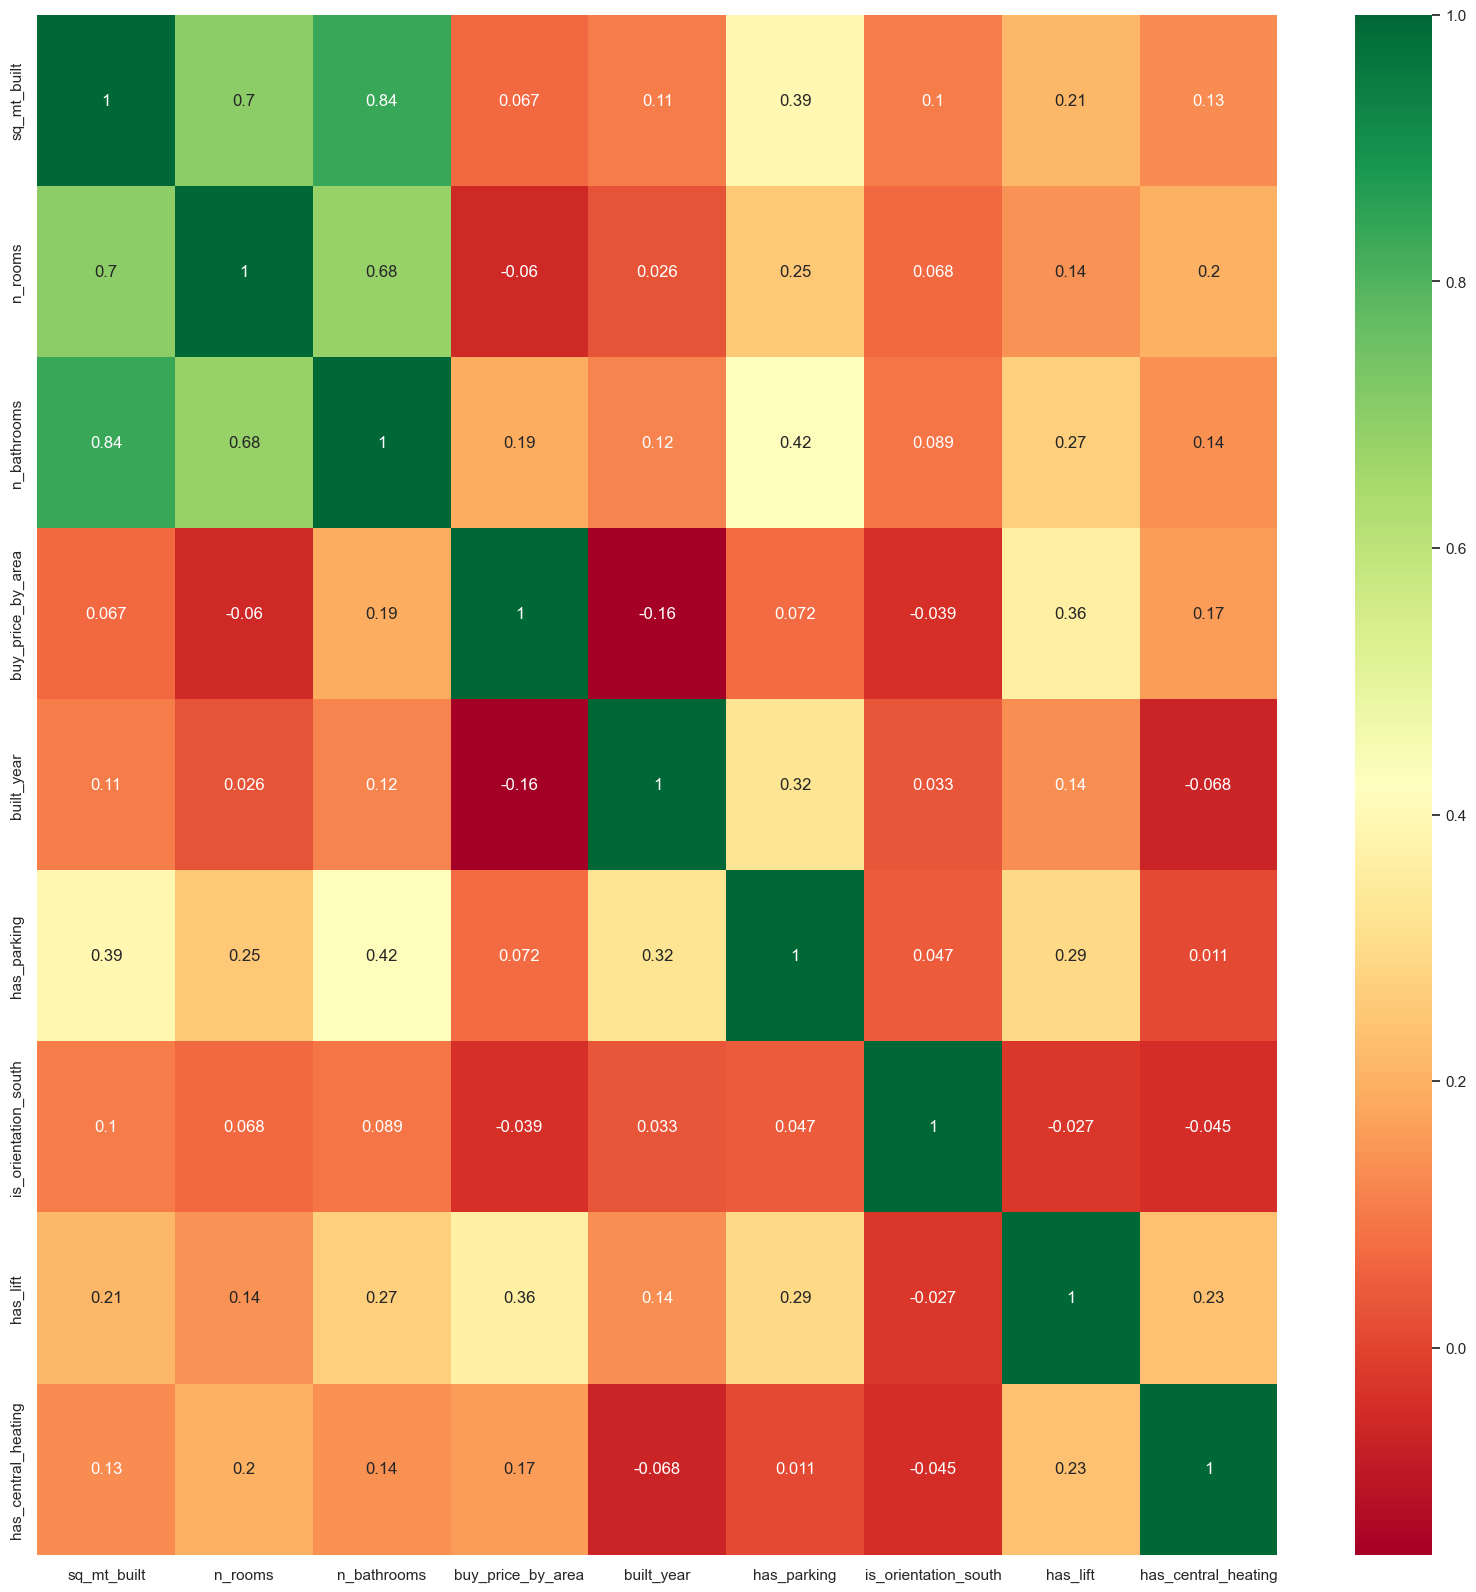

In [17]:
import seaborn as sns
columns_to_fill = data.columns[:-2]
print(columns_to_fill)
corrmat = data[columns_to_fill].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Now it's much more clear what the correlation is between all the datasets. For the green, we have high correlation and for the red, we have little to no correlation between the parameters in the dataset. Most of the parameters have at least some correlation with log price, which is a good indicator that the logic applied at the beginning has some merit.

In [18]:
# statsmodels will be used for checking multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

# declaring a variable to put all features to check for multicollinearity, 
# it cannot include categorical data so the features will be typed manually
variables = data[['sq_mt_built', 'n_bathrooms', 'built_year', 'buy_price_by_area', 'n_rooms']]

#create a new data frame which will include all the VIFs
vif = pd.DataFrame()

# make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
# include names to make it easier to explore the result
vif["Features"] = variables.columns

vif

,VIF,Features
0,10.101336,sq_mt_built
1,14.854578,n_bathrooms
2,11.391233,built_year
3,6.561685,buy_price_by_area
4,12.194722,n_rooms


Since number of bathrooms and number of rooms have high VIF, one of them will be removed from the model. This will drive the VIF of other variables down. So even if sq_mt_built seems with a high VIF, too, once the n_bathrooms feature is removed that will no longer be the case.

In [19]:
data = data.drop(['n_bathrooms'],axis=1)

#let's check vif again
variables = data[['built_year','sq_mt_built','n_rooms', 'buy_price_by_area']]

vif = pd.DataFrame()

vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]

vif["Features"] = variables.columns

vif

,VIF,Features
0,11.390730,built_year
1,5.378013,sq_mt_built
2,11.135439,n_rooms
3,6.005671,buy_price_by_area


The VIF score of n_rooms is above the 5 threshold, so it has to be removed as well.

In [20]:
data = data.drop(['n_rooms'],axis=1)

#let's check vif again
variables = data[['built_year','sq_mt_built', 'buy_price_by_area']]

vif = pd.DataFrame()

vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]

vif["Features"] = variables.columns

vif

,VIF,Features
0,7.194098,built_year
1,2.704413,sq_mt_built
2,5.880915,buy_price_by_area


Seeing as the buy_price_by_area variable is quite similar to the variable to be predicted, it will be dropped.

In [21]:
data = data.drop(['buy_price_by_area'],axis=1)
#let's check vif again
variables = data[['built_year','sq_mt_built']]

vif = pd.DataFrame()

vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]

vif["Features"] = variables.columns

vif

,VIF,Features
0,2.692488,built_year
1,2.692488,sq_mt_built


 Creating dummies for real estate location feature, to be used in regression

In [22]:
# The location data seems like a logical feature to include in a real estate prediction model
dummies_subtitle = pd.get_dummies(data['subtitle'], drop_first=True)
# drop_first makes sure no multicollinearity will occur between first dummy and others

data = pd.concat([dummies_subtitle, data],axis=1)
#uniting the two datasets
data.head()

,"Abrantes, Madrid","Acacias, Madrid","Adelfas, Madrid","Alameda de Osuna, Madrid","Almagro, Madrid","Almendrales, Madrid","Aluche, Madrid","Ambroz, Madrid","Apóstol Santiago, Madrid","Arapiles, Madrid","Aravaca, Madrid","Arganzuela, Madrid","Argüelles, Madrid","Arroyo del Fresno, Madrid","Atalaya, Madrid","Barajas, Madrid","Barrio de Salamanca, Madrid","Bellas Vistas, Madrid","Bernabéu-Hispanoamérica, Madrid","Berruguete, Madrid","Buena Vista, Madrid","Butarque, Madrid","Campamento, Madrid","Campo de las Naciones-Corralejos, Madrid","Canillas, Madrid","Carabanchel, Madrid","Casa de Campo, Madrid","Casco Histórico de Barajas, Madrid","Casco Histórico de Vallecas, Madrid","Casco Histórico de Vicálvaro, Madrid","Castellana, Madrid","Castilla, Madrid","Centro, Madrid","Chamartín, Madrid","Chamberí, Madrid","Chopera, Madrid","Chueca-Justicia, Madrid","Ciudad Jardín, Madrid","Ciudad Lineal, Madrid","Ciudad Universitaria, Madrid","Colina, Madrid","Comillas, Madrid","Concepción, Madrid","Conde Orgaz-Piovera, Madrid","Costillares, Madrid","Cuatro Caminos, Madrid","Cuatro Vientos, Madrid","Cuzco-Castillejos, Madrid","Delicias, Madrid","El Cañaveral - Los Berrocales, Madrid","El Pardo, Madrid","El Plantío, Madrid","El Viso, Madrid","Ensanche de Vallecas - La Gavia, Madrid","Entrevías, Madrid","Estrella, Madrid","Fontarrón, Madrid","Fuencarral, Madrid","Fuente del Berro, Madrid","Fuentelarreina, Madrid","Gaztambide, Madrid","Goya, Madrid","Guindalera, Madrid","Horcajo, Madrid","Hortaleza, Madrid","Huertas-Cortes, Madrid","Ibiza, Madrid","Imperial, Madrid","Jerónimos, Madrid","La Paz, Madrid","Las Tablas, Madrid","Latina, Madrid","Lavapiés-Embajadores, Madrid","Legazpi, Madrid","Lista, Madrid","Los Cármenes, Madrid","Los Rosales, Madrid","Los Ángeles, Madrid","Lucero, Madrid","Malasaña-Universidad, Madrid","Marroquina, Madrid","Media Legua, Madrid","Mirasierra, Madrid","Moncloa, Madrid","Montecarmelo, Madrid","Moratalaz, Madrid","Moscardó, Madrid","Niño Jesús, Madrid","Nueva España, Madrid","Nuevos Ministerios-Ríos Rosas, Madrid","Numancia, Madrid","Opañel, Madrid","Orcasitas, Madrid","Pacífico, Madrid","Palacio, Madrid","Palomas, Madrid","Palomeras Bajas, Madrid","Palomeras sureste, Madrid","Palos de Moguer, Madrid","Pau de Carabanchel, Madrid","Pavones, Madrid","Peñagrande, Madrid","Pilar, Madrid","Pinar del Rey, Madrid","Portazgo, Madrid","Pradolongo, Madrid","Prosperidad, Madrid","Pueblo Nuevo, Madrid","Puente de Vallecas, Madrid","Puerta Bonita, Madrid","Puerta del Ángel, Madrid","Quintana, Madrid","Recoletos, Madrid","Retiro, Madrid","San Andrés, Madrid","San Cristóbal, Madrid","San Diego, Madrid","San Fermín, Madrid","San Isidro, Madrid","San Juan Bautista, Madrid","San Pascual, Madrid","Sanchinarro, Madrid","Santa Eugenia, Madrid","Sol, Madrid","Tetuán, Madrid","Timón, Madrid","Trafalgar, Madrid","Tres Olivos - Valverde, Madrid","Usera, Madrid","Valdeacederas, Madrid","Valdebebas - Valdefuentes, Madrid","Valdebernardo - Valderribas, Madrid","Valdemarín, Madrid","Valdezarza, Madrid","Vallehermoso, Madrid","Ventas, Madrid","Ventilla-Almenara, Madrid","Vicálvaro, Madrid","Villa de Vallecas, Madrid","Villaverde, Madrid","Vinateros, Madrid","Virgen del Cortijo - Manoteras, Madrid","Vista Alegre, Madrid","Zofío, Madrid","Águilas, Madrid",sq_mt_built,built_year,has_parking,is_orientation_south,has_lift,has_central_heating,subtitle,log_price
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

Now, the dataframe includes a column for each subtitle (neighbourhood) of Madrid, with binary outcome (e.g. Is the real estate located in X neighhbourhood? -> outcome yes/no, or 1-0). These parameters can be used in the algorithms for real estate price prediction.

# Random Forest

In [47]:
data.head()

,"Abrantes, Madrid","Acacias, Madrid","Adelfas, Madrid","Alameda de Osuna, Madrid","Almagro, Madrid","Almendrales, Madrid","Aluche, Madrid","Ambroz, Madrid","Apóstol Santiago, Madrid","Arapiles, Madrid","Aravaca, Madrid","Arganzuela, Madrid","Argüelles, Madrid","Arroyo del Fresno, Madrid","Atalaya, Madrid","Barajas, Madrid","Barrio de Salamanca, Madrid","Bellas Vistas, Madrid","Bernabéu-Hispanoamérica, Madrid","Berruguete, Madrid","Buena Vista, Madrid","Butarque, Madrid","Campamento, Madrid","Campo de las Naciones-Corralejos, Madrid","Canillas, Madrid","Carabanchel, Madrid","Casa de Campo, Madrid","Casco Histórico de Barajas, Madrid","Casco Histórico de Vallecas, Madrid","Casco Histórico de Vicálvaro, Madrid","Castellana, Madrid","Castilla, Madrid","Centro, Madrid","Chamartín, Madrid","Chamberí, Madrid","Chopera, Madrid","Chueca-Justicia, Madrid","Ciudad Jardín, Madrid","Ciudad Lineal, Madrid","Ciudad Universitaria, Madrid","Colina, Madrid","Comillas, Madrid","Concepción, Madrid","Conde Orgaz-Piovera, Madrid","Costillares, Madrid","Cuatro Caminos, Madrid","Cuatro Vientos, Madrid","Cuzco-Castillejos, Madrid","Delicias, Madrid","El Cañaveral - Los Berrocales, Madrid","El Pardo, Madrid","El Plantío, Madrid","El Viso, Madrid","Ensanche de Vallecas - La Gavia, Madrid","Entrevías, Madrid","Estrella, Madrid","Fontarrón, Madrid","Fuencarral, Madrid","Fuente del Berro, Madrid","Fuentelarreina, Madrid","Gaztambide, Madrid","Goya, Madrid","Guindalera, Madrid","Horcajo, Madrid","Hortaleza, Madrid","Huertas-Cortes, Madrid","Ibiza, Madrid","Imperial, Madrid","Jerónimos, Madrid","La Paz, Madrid","Las Tablas, Madrid","Latina, Madrid","Lavapiés-Embajadores, Madrid","Legazpi, Madrid","Lista, Madrid","Los Cármenes, Madrid","Los Rosales, Madrid","Los Ángeles, Madrid","Lucero, Madrid","Malasaña-Universidad, Madrid","Marroquina, Madrid","Media Legua, Madrid","Mirasierra, Madrid","Moncloa, Madrid","Montecarmelo, Madrid","Moratalaz, Madrid","Moscardó, Madrid","Niño Jesús, Madrid","Nueva España, Madrid","Nuevos Ministerios-Ríos Rosas, Madrid","Numancia, Madrid","Opañel, Madrid","Orcasitas, Madrid","Pacífico, Madrid","Palacio, Madrid","Palomas, Madrid","Palomeras Bajas, Madrid","Palomeras sureste, Madrid","Palos de Moguer, Madrid","Pau de Carabanchel, Madrid","Pavones, Madrid","Peñagrande, Madrid","Pilar, Madrid","Pinar del Rey, Madrid","Portazgo, Madrid","Pradolongo, Madrid","Prosperidad, Madrid","Pueblo Nuevo, Madrid","Puente de Vallecas, Madrid","Puerta Bonita, Madrid","Puerta del Ángel, Madrid","Quintana, Madrid","Recoletos, Madrid","Retiro, Madrid","San Andrés, Madrid","San Cristóbal, Madrid","San Diego, Madrid","San Fermín, Madrid","San Isidro, Madrid","San Juan Bautista, Madrid","San Pascual, Madrid","Sanchinarro, Madrid","Santa Eugenia, Madrid","Sol, Madrid","Tetuán, Madrid","Timón, Madrid","Trafalgar, Madrid","Tres Olivos - Valverde, Madrid","Usera, Madrid","Valdeacederas, Madrid","Valdebebas - Valdefuentes, Madrid","Valdebernardo - Valderribas, Madrid","Valdemarín, Madrid","Valdezarza, Madrid","Vallehermoso, Madrid","Ventas, Madrid","Ventilla-Almenara, Madrid","Vicálvaro, Madrid","Villa de Vallecas, Madrid","Villaverde, Madrid","Vinateros, Madrid","Virgen del Cortijo - Manoteras, Madrid","Vista Alegre, Madrid","Zofío, Madrid","Águilas, Madrid",sq_mt_built,built_year,has_parking,subtitle,log_price
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [48]:
# firstly, let's drop variables with lesser explanatory power
data = data.drop(['is_orientation_south', 'has_lift','has_central_heating'],axis=1)
# as a final step, we ought to remove the 'subtitle' column as it was already converted to dummies
data_preprocessed = data.drop(['subtitle'],axis=1)

data_preprocessed.head()

KeyError: "['is_orientation_south', 'has_lift', 'has_central_heating'] not found in axis"

In [ ]:
# The target (dependent variable) is 'log_price'
targets = data_preprocessed['log_price']

# The inputs are everything BUT the dependent variable, so we can simply drop it
inputs = data_preprocessed.drop(['log_price'],axis=1)

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load your dataset and split it into inputs and targets (inputs, targets)

# Standardize the inputs
scaler = StandardScaler()
scaler.fit(inputs)
inputs_scaled = scaler.fit_transform(inputs)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=42)

# Create a RandomForestRegressor model
rf = RandomForestRegressor(random_state=42)

# Define a dictionary of hyperparameters and their possible values to search through
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']  # Only include valid values for max_features
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV object to the training data to find the best hyperparameters
grid_search.fit(x_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Create a new RandomForestRegressor model with the best hyperparameters
best_rf = RandomForestRegressor(random_state=42, **best_params)

# Train the model with the best hyperparameters on the full training dataset
best_rf.fit(x_train, y_train)

# Make predictions on the testing data
y_hat_rf_test = best_rf.predict(x_test)

# Calculate metrics
mae_test = mean_absolute_error(y_test, y_hat_rf_test)
mse_test = mean_squared_error(y_test, y_hat_rf_test)
rmse_test = mean_squared_error(y_test, y_hat_rf_test, squared=False)
r2_test = r2_score(y_test, y_hat_rf_test)



# Print the best hyperparameters and test metrics
print("Best Hyperparameters:", best_params)
print('\nMean Absolute Error (Test):', mae_test)
print('Mean Squared Error (Test):', mse_test)
print('Root Mean Squared Error (Test):', rmse_test)
print('R-squared Score (Test):', r2_test)


Best Hyperparameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

Mean Absolute Error (Test): 0.17143489326060687
Mean Squared Error (Test): 0.053298520407836836
Root Mean Squared Error (Test): 0.23086472317752843
R-squared Score (Test): 0.9175943455193682


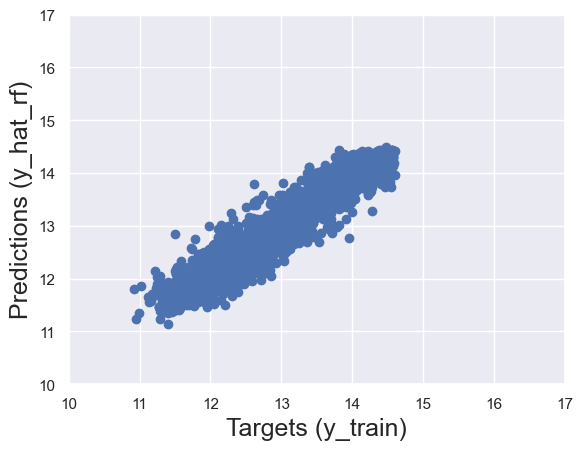

In [27]:
plt.scatter(y_test, y_hat_rf_test)

plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat_rf)',size=18)


plt.xlim(10,17)
plt.ylim(10,17)
plt.show()

Text(0.5, 1.0, 'Residuals PDF')

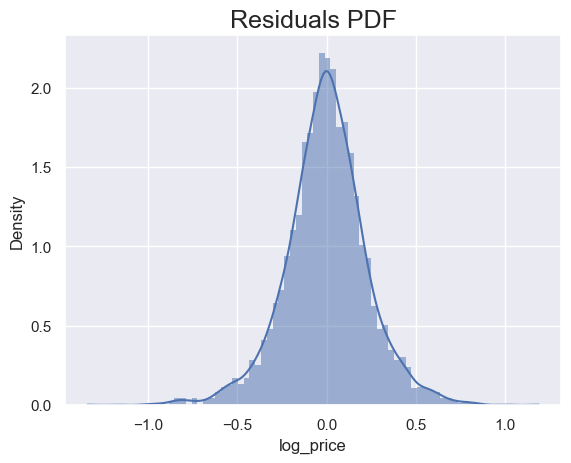

In [45]:
sns.histplot(y_test - y_hat_rf_test, kde=True, stat="density", linewidth=0)

plt.title("Residuals PDF", size=18)

In [46]:
# Find the R-squared of the model
from sklearn.metrics import r2_score

r2 = r2_score (y_test, y_hat_rf_test)

print ('R-squared score', round (r2,2))


R-squared score 0.92


Let's try the model on the test values now. It's possible that the model has overfitted, so in order to test its true predictive ability, the model must be given a dataset it has not been trained on.

In [54]:
import pickle

# Save the trained model to a pickle file
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(best_rf, file)

best_rf

RandomForestRegressor(max_features='log2', min_samples_split=10,
                      random_state=42)

In [34]:
    location_names = [
    'Abrantes, Madrid', 'Acacias, Madrid', 'Adelfas, Madrid', 'Alameda de Osuna, Madrid', 'Almagro, Madrid',
    'Almendrales, Madrid', 'Aluche, Madrid', 'Ambroz, Madrid', 'Apóstol Santiago, Madrid', 'Arapiles, Madrid',
    'Aravaca, Madrid', 'Arganzuela, Madrid', 'Argüelles, Madrid', 'Arroyo del Fresno, Madrid', 'Atalaya, Madrid',
    'Barajas, Madrid', 'Barrio de Salamanca, Madrid', 'Bellas Vistas, Madrid', 'Bernabéu-Hispanoamérica, Madrid',
    'Berruguete, Madrid', 'Buena Vista, Madrid', 'Butarque, Madrid', 'Campamento, Madrid',
    'Campo de las Naciones-Corralejos, Madrid', 'Canillas, Madrid', 'Carabanchel, Madrid', 'Casa de Campo, Madrid',
    'Casco Histórico de Barajas, Madrid', 'Casco Histórico de Vallecas, Madrid', 'Casco Histórico de Vicálvaro, Madrid',
    'Castellana, Madrid', 'Castilla, Madrid', 'Centro, Madrid', 'Chamartín, Madrid', 'Chamberí, Madrid',
    'Chopera, Madrid',
    'Chueca-Justicia, Madrid', 'Ciudad Jardín, Madrid', 'Ciudad Lineal, Madrid', 'Ciudad Universitaria, Madrid',
    'Colina, Madrid', 'Comillas, Madrid', 'Concepción, Madrid', 'Conde Orgaz-Piovera, Madrid', 'Costillares, Madrid',
    'Cuatro Caminos, Madrid', 'Cuatro Vientos, Madrid', 'Cuzco-Castillejos, Madrid', 'Delicias, Madrid',
    'El Cañaveral - Los Berrocales, Madrid', 'El Pardo, Madrid', 'El Plantío, Madrid', 'El Viso, Madrid',
    'Ensanche de Vallecas - La Gavia, Madrid', 'Entrevías, Madrid', 'Estrella, Madrid', 'Fontarrón, Madrid',
    'Fuencarral, Madrid', 'Fuente del Berro, Madrid', 'Fuentelarreina, Madrid', 'Gaztambide, Madrid', 'Goya, Madrid',
    'Guindalera, Madrid', 'Horcajo, Madrid', 'Hortaleza, Madrid', 'Huertas-Cortes, Madrid', 'Ibiza, Madrid',
    'Imperial, Madrid', 'Jerónimos, Madrid', 'La Paz, Madrid', 'Las Tablas, Madrid', 'Latina, Madrid',
    'Lavapiés-Embajadores, Madrid', 'Legazpi, Madrid', 'Lista, Madrid', 'Los Cármenes, Madrid', 'Los Rosales, Madrid',
    'Los Ángeles, Madrid', 'Lucero, Madrid', 'Malasaña-Universidad, Madrid', 'Marroquina, Madrid',
    'Media Legua, Madrid',
    'Mirasierra, Madrid', 'Moncloa, Madrid', 'Montecarmelo, Madrid', 'Moratalaz, Madrid', 'Moscardó, Madrid',
    'Niño Jesús, Madrid', 'Nueva España, Madrid', 'Nuevos Ministerios-Ríos Rosas, Madrid', 'Numancia, Madrid',
    'Opañel, Madrid', 'Orcasitas, Madrid', 'Pacífico, Madrid', 'Palacio, Madrid', 'Palomas, Madrid',
    'Palomeras Bajas, Madrid', 'Palomeras sureste, Madrid', 'Palos de Moguer, Madrid', 'Pau de Carabanchel, Madrid',
    'Pavones, Madrid', 'Peñagrande, Madrid', 'Pilar, Madrid', 'Pinar del Rey, Madrid', 'Portazgo, Madrid',
    'Pradolongo, Madrid', 'Prosperidad, Madrid', 'Pueblo Nuevo, Madrid', 'Puente de Vallecas, Madrid',
    'Puerta Bonita, Madrid', 'Puerta del Ángel, Madrid', 'Quintana, Madrid', 'Recoletos, Madrid', 'Retiro, Madrid',
    'San Andrés, Madrid', 'San Cristóbal, Madrid', 'San Diego, Madrid', 'San Fermín, Madrid', 'San Isidro, Madrid',
    'San Juan Bautista, Madrid', 'San Pascual, Madrid', 'Sanchinarro, Madrid', 'Santa Eugenia, Madrid', 'Sol, Madrid',
    'Tetuán, Madrid', 'Timón, Madrid', 'Trafalgar, Madrid', 'Tres Olivos - Valverde, Madrid', 'Usera, Madrid',
    'Valdeacederas, Madrid', 'Valdebebas - Valdefuentes, Madrid', 'Valdebernardo - Valderribas, Madrid',
    'Valdemarín, Madrid', 'Valdezarza, Madrid', 'Vallehermoso, Madrid', 'Ventas, Madrid', 'Ventilla-Almenara, Madrid',
    'Vicálvaro, Madrid', 'Villa de Vallecas, Madrid', 'Villaverde, Madrid', 'Vinateros, Madrid',
    'Virgen del Cortijo - Manoteras, Madrid', 'Vista Alegre, Madrid', 'Zofío, Madrid', 'Águilas, Madrid']

In [41]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

def predict_price(location, sq_mt_built, built_year, has_parking, model, scaler, location_names):
    # Create a dictionary to hold the input data
    input_data = {}
    
    # Set the location dummy variable
    for loc in location_names:
        input_data[loc] = 1 if loc == location else 0

    # Add the other input features to the dictionary
    input_data['sq_mt_built'] = sq_mt_built
    input_data['built_year'] = built_year
    input_data['has_parking'] = has_parking

    # Convert the input data into a DataFrame
    input_df = pd.DataFrame([input_data])

    # Standardize the input data using the previously trained scaler
    input_scaled = scaler.transform(input_df)

    # Make the prediction using the model
    prediction = model.predict(input_scaled)

    return prediction

# Define the input values for prediction
location = 'Virgen del Cortijo - Manoteras, Madrid'  # Choose a location from your list
sq_mt_built = 200  # Example square meters built
built_year = 2000  # Example year built
has_parking = 1  # 1 if the property has parking, 0 if not

In [42]:
# Make the prediction
predicted_price = predict_price(location, sq_mt_built, built_year, has_parking, best_rf, scaler, location_names)
predicted_price_original_scale = np.exp(predicted_price[0])


# Print the predicted price
# Print the predicted price with more decimal places
print(f'Predicted Price: {predicted_price_original_scale:.2f} Euros')


Predicted Price: 699777.11 Euros


In [43]:
def predict_price(location_data, input_data):
    # Create a dictionary to hold the input data
    input_dict = {}
    
    # Set the location dummy variable
    for loc in location_data:
        input_dict[loc] = 1 if loc == input_data['location'] else 0

    # Add the other input features to the dictionary
    input_dict['sq_mt_built'] = input_data['sq_mt_built']
    input_dict['built_year'] = input_data['built_year']
    input_dict['has_parking'] = input_data['has_parking']

    # Convert the input data into a DataFrame
    input_df = pd.DataFrame([input_dict])

    # Standardize the input data using the previously trained scaler
    input_scaled = scaler.transform(input_df)

    # Make the prediction using the model
    prediction = best_rf.predict(input_scaled)

    return prediction

# Define the input values for prediction
input_data = {
    'location': 'Barrio Salamanca, Madrid',
    'sq_mt_built': 200,  # Example square meters built
    'built_year': 2000,  # Example year built
    'has_parking': 1,  # 1 if the property has parking, 0 if not
}

In [44]:
# Make the prediction
predicted_price = predict_price(location_names, input_data)

# Print the predicted price
predicted_price_original_scale = np.exp(predicted_price[0])
print(f'Predicted Price: {predicted_price_original_scale:.2f} Euros')


Predicted Price: 794766.10 Euros
